Fine-tuning Transformers from Hugging Face using Trainer

In [1]:
! pip -q install transformers
! pip -q install datasets

In [ ]:
# Install the latest versions of datasets, huggingface_hub, and fsspec
# to ensure compatibility with the latest features and bug fixes.
! pip install -U datasets huggingface_hub fsspec

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 118.6 MB/s eta 0:00:00
Using cached multiprocess-0.70.16-py311-none-any.whl (143 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:
      Successfully uninstalled dill-0.4.0
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.18
    Uninstalling multiprocess-0.70.18:
 

In [ ]:
import os
from datasets import load_dataset, DatasetDict
from transformers import MobileViTFeatureExtractor
import shutil
import torch
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
import seaborn as sns

2025-06-09 17:16:34.010734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 17:16:34.026761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 17:16:34.031899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 17:16:34.044268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# search and delete all the .ipynb_checkpoints folders
base_folder = "your_base_folder_path"  # Replace with your base folder path

# Walk through the directory
for root, dirs, _ in os.walk(base_folder):
    for dir_name in dirs:
        if dir_name == ".ipynb_checkpoints":
            folder_path = os.path.join(root, dir_name)
            try:
                shutil.rmtree(folder_path)  # Delete the folder
                print(f"Deleted folder: {folder_path}")
            except Exception as e:
                print(f"Error deleting folder {folder_path}: {e}")

In [3]:
def get_png_files(img_dir):
    png_files = []
    for subdir, _, files in os.walk(img_dir):
        for file in files:
            if file.endswith('.png'):
                # Get the absolute path and add it to the list
                png_files.append(os.path.abspath(os.path.join(subdir, file)))
    return png_files

In [ ]:
pos = "your_negative_images_path"  # Replace with your negative images path
neg = "your_positive_images_path"  # Replace with your positive images path
pos_files = get_png_files(pos)
neg_files = get_png_files(neg)

print(f"positive: {len(pos_files)}")
print(f"negative: {len(neg_files)}")

positive: 151
negative: 542


In [ ]:
neg_folder = "your_negative_train_images_path"  # Replace with your negative train images path
pos_folder = "your_positive_train_images_path"  # Replace with your positive train images path
neg_val_folder = "your_negative_val_images_path"  # Replace with your negative validation images path
pos_val_folder = "your_positive_val_images_path"  # Replace with your positive validation images path

neg_files = get_png_files(neg_folder)
pos_files = get_png_files(pos_folder)
neg_val_files = get_png_files(neg_val_folder)
pos_val_files = get_png_files(pos_val_folder)
print(f"positive train images: {len(neg_files)}")
print(f"negative train images: {len(pos_files)}")
print(f"positive val images: {len(neg_val_files)}")
print(f"negative val images: {len(pos_val_files)}")

positive train images: 151
negative train images: 542
positive val images: 39
negative val images: 137


In [10]:
# helper function for weighted random sampler

def get_class_weights(dataset):
    class_counts = {}
    for example in dataset:
        label = example['label']
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    total_count = sum(class_counts.values())
    class_weights = {label: total_count / count for label, count in class_counts.items()}
    return class_weights


def get_sample_weights(dataset, class_weights):
    sample_weights = [class_weights[example['label']] for example in dataset]
    return sample_weights

In [ ]:
# Path to the dataset directory
# possible error and fix.
# pip install -U datasets huggingface_hub fsspec

data_dir = "your_dataset_directory"  # Replace with your dataset directory path

train_dataset = load_dataset("imagefolder", data_dir=f"{data_dir}/train")
val_dataset = load_dataset("imagefolder", data_dir=f"{data_dir}/val")

train_dataset["train"] = train_dataset["train"].shuffle(seed=42)
val_dataset["train"] = val_dataset["train"].shuffle(seed=42)

dataset = DatasetDict({
    "train": train_dataset["train"],
    "val": val_dataset["train"],
})

print(dataset)

Resolving data files:   0%|          | 0/693 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/176 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 693
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 176
    })
})


In [9]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None)}

In [11]:
# set up the weighted sampler
train_class_weights = get_class_weights(train_dataset["train"])
train_sample_weights = get_sample_weights(train_dataset["train"], train_class_weights)
train_sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights))
labels = dataset['train'].features['label'].names

In [14]:
labels = dataset['train'].features['label'].names
print(labels)

['negative', 'positive']


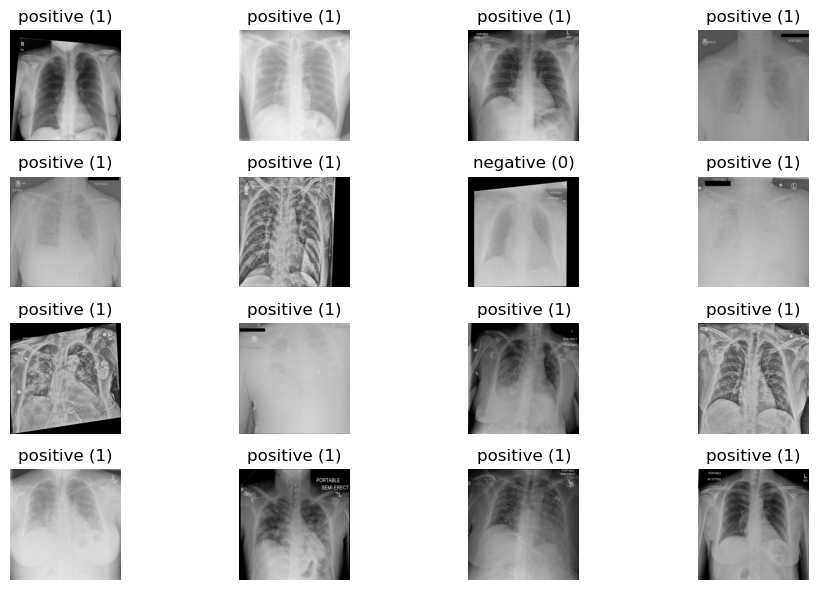

In [15]:
batch = dataset['train'].select(range(16))
pointer = 0
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,6))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(batch[pointer]['image'], cmap='gray')
        ax[i,j].set_title(f"{labels[batch[pointer]['label']]} ({batch[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1

fig.tight_layout()
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mobile vit
model_name = "apple/mobilevit-small"
image_processor = MobileViTFeatureExtractor.from_pretrained(model_name)

/opt/conda/lib/python3.11/site-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


In [ ]:
def preprocess_data(example_batch):
    inputs = image_processor(example_batch['image'], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs


# Apply the transforms to the dataset
processed_dataset = dataset.with_transform(preprocess_data)

In [18]:
processed_dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None)}

In [19]:
# Define collate_fn
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [21]:
# Apply the transforms to the dataset
processed_dataset = dataset.with_transform(preprocess_data)
train_dataloader = torch.utils.data.DataLoader(
    processed_dataset["train"], sampler=train_sampler, batch_size=32, collate_fn=collate_fn
)
val_dataloader = torch.utils.data.DataLoader(
    processed_dataset["val"], batch_size=32, collate_fn=collate_fn
)

# train_dataloader = torch.utils.data.DataLoader(
#     processed_dataset["train"], batch_size=32, collate_fn=collate_fn
# )
# val_dataloader = torch.utils.data.DataLoader(
#     processed_dataset["val"], batch_size=32, collate_fn=collate_fn
# )

In [ ]:
# define the training metrics
from transformers import ViTForImageClassification, SwinForImageClassification, AutoModelForImageClassification, MobileViTForImageClassification, ConvNextV2ForImageClassification
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import torch.nn as nn

labels = dataset['train'].features['label'].names
num_classes = 2

model = AutoModelForImageClassification.from_pretrained(model_name)


def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    auc = roc_auc_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'auc': auc,
        'precision': precision,
        'recall': recall,
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir='your_output_directory',  # Replace with your output directory
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=50,
                                  fp16=True if torch.cuda.is_available() else False,
                                  # save_steps=100,
                                  # eval_steps=100,
                                  logging_dir="your_logging_directory",  # Replace with your logging directory
                                  logging_steps=10,
                                  learning_rate=1e-4,
                                  weight_decay=0.01,
                                  save_total_limit=2,
                                  dataloader_num_workers=4,
                                  remove_unused_columns=False,
                                  report_to='tensorboard',
                                  push_to_hub=False,
                                  metric_for_best_model = 'accuracy',
                                  load_best_model_at_end=True)

In [ ]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return train_dataloader  # Use the custom DataLoader for training

    def get_eval_dataloader(self, eval_dataset=None):
        return val_dataloader  # Use the custom DataLoader for evaluation


In [25]:
from transformers import Trainer, TrainingArguments

trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)

/tmp/ipykernel_5190/3901715386.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
train_results = trainer.train()
trainer.save_model("your_model_directory")  # Replace with your model directory

trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc,Precision,Recall
1,6.322000,5.948265,0.085227,0.116627,0.682014,0.184659,0.085227
2,4.468400,3.186157,0.636364,0.708475,0.675370,0.801814,0.636364
3,2.441100,1.945136,0.738636,0.753992,0.699607,0.780397,0.738636
4,1.096800,0.883169,0.846591,0.845874,0.773068,0.845224,0.846591
5,0.468000,0.492489,0.875000,0.868010,0.772974,0.869429,0.875000
6,0.323600,0.504244,0.880682,0.878942,0.813307,0.877881,0.880682
7,0.167700,0.464272,0.892045,0.881995,0.774752,0.894475,0.892045
8,0.129900,0.544343,0.875000,0.868010,0.772974,0.869429,0.875000
9,0.041300,0.603991,0.886364,0.881482,0.798615,0.881955,0.886364
10,0.049200,0.634997,0.892045,0.886722,0.802265,0.888426,0.892045


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classifi

***** train metrics *****
  epoch                    =        50.0
  total_flos               = 212365281GF
  train_loss               =      0.3491
  train_runtime            =  0:05:32.42
  train_samples_per_second =     104.235
  train_steps_per_second   =       3.309
